# 들어가며

**학습목표**
___
- 명확한 정답 데이터가 label로 달려있지 않은 데이터들을 다루는 비지도학습에 대해 알아보자.
- 비지도학습의 개념, 지도학습과 비지도학습의 차이, 주요 비지도학습 알고리즘에 대해 알아보자.

**목차**
___
 1. 비지도학습(Unsupervised Learning)에 대하여
 2. 클러스터링(1) K-means
 3. 클러스터링(2) DBSCAN
 4. 차원 축소(1) PCA
 5. 차원 축소(2) T-SNE
 6. 정리 및 요약

# 비지도학습(Unsupervised Learning)에 대하여

`Unsupervised Learning`: machine learning algorithms to analyze and cluster unlabeled datasets

대표적인 예로는 **군집화(clustering)**이 있지만, 비지도학습이라는 용어는 정답이 없는 데이터를 이용한 학습 전체를 포괄하는 용어이기 때문에 클러스터링 외에도 **차원 축소, 이를 이용한 시각화, 생성 모델 등의 다양한 task**를 포괄하는 개념이다.

이번 시간에는 클러스터링의 대표적인 알고리즘인 K-means와 DBSCAN 알고리즘, PCA(Principal Component Analysis), T-SNE에 대해 다뤄보자.

# 클러스터링(1) K-means

클러스터링: 명확한 기준이 없는 상황에서도 데이터들을 분석하여 가까운 것들끼리 묶어주는 작업. 이를 통해 개별적인 데이터들을 그룹으로 추상화하여 새로운 의미를 발견해 나갈 수 있다.

`K-means Algorithm`:  Unsupervised Learning algorithm, which groups the unlabeled dataset into different clusters.

코드를 보며 어떻게 K-means 알고리즘이 동작하는지 보자.

## 1. 데이터 생성
모듈 import후 5개의 중심점을 기준으로 무작위 점 데이터 100개를 생성해 준다.

In [50]:
%matplotlib inline
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings

warnings.filterwarnings(action='ignore')
# 중심점이 5개인 100개의 점 데이터를 무작위로 생성합니다.
points, labels = make_blobs(n_samples=100, centers=5, n_features=2, random_state=135)

print(points.shape, points[:10])  # 무작위로 생성된 점의 좌표 10개 출력
print(labels.shape, labels[:10])    # 10개의 점들이 각각 대응하는 중심점(label) 값 출력

(100, 2) [[ 4.63411914 -6.52590383]
 [-6.52008604  7.16624288]
 [ 2.14142339 -5.21092623]
 [ 1.70054231  8.54077897]
 [-0.33809159  8.76509668]
 [-7.69329744  7.94546313]
 [ 3.89090121 -3.06531839]
 [ 3.22338498 -2.93209009]
 [-6.63962964  5.34777334]
 [ 6.37904965 -6.46617328]]
(100,) [2 1 0 3 3 1 0 0 1 2]


임의로 지정한 k개의 중심점이 새로운 label역할을 하는 것이 K-means의 아이디어이다.

,X,Y
0,4.634119,-6.525904
1,-6.520086,7.166243
2,2.141423,-5.210926
3,1.700542,8.540779
4,-0.338092,8.765097


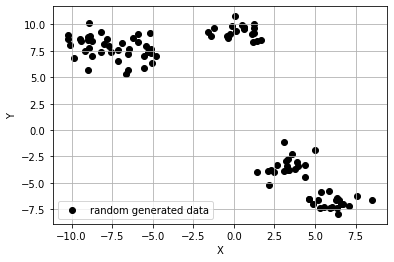

In [2]:
# 이후, 생성한 데이터를 좌표에 그려보기

# 축 그리기
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# 위에서 생성한 점 데이터들을 pandas DataFrame 형태로 변환하기
points_df = pd.DataFrame(points, columns=['X', 'Y'])
display(points_df.head())

# 점 데이터를 X-Y grid에 시각화하기
ax.scatter(points[:, 0], points[:, 1], c='black', label='random generated data')

# 축 이름을 라벨에 달고, 점 데이터 그리기
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid()

위와 같이 `make_blob()`을 활용하여 중심점이 5개이니 무작위의 점 데이터 100개를 생성했다. 이제 알고리즘으로 위 데이터들을 올바르게 군집화할 수 있는지 알아보자.

## 2. 생성한 데이터에 K-means 알고리즘 적용

이제 K-means 알고리즘을 적용하자. L2 distance로 거리를 계산하자.

[유클리디안 거리](http://egloos.zum.com/metashower/v/9957577)

전체적인 K-mean 알고리즘은 다음과 같이 구성된다.

1. 원하는 클러스터의 수 K를 결정한다.
2. 무작위로 클러스터의 수와 같은 K개의 중심점(centroid)을 선정한다. 이들은 각각의 클러스터를 대표한다.
3. 나머지 점들과 모든 중심점 간의 유클리드 거리를 계산한 후, 가장 가까운 거리를 가지는 중심점의 클러스터에 속하게 한다.
4. 각 K개의 중심점을 재종한다. 특정 클러스터에 속하는 모든 점들의 평균값이 해당 클러스터 다음 iter의 중심점이 된다.
5. 재조정된 중심점을 바탕으로 모든 점들과 새로 조정된 중심점 간의 유클리드 거리를 다시 계산한 후, 가장 가까운 거리를 가지는 클러스터에 해당점을 재배정한다.
6. 4~5번을 반복 수행. 특정 iter 이상이 되면 수렴(중심점이 바뀌지 않음)하게 된다.

위 과정들을 코드로 살펴보자.

In [3]:
from sklearn.cluster import KMeans

# 1), 2) 위에서 생성한 무작위 점 데이터(points)에 클러스터의 수(K)가 5인 K-means 알고리즘을 적용 
kmeans_cluster = KMeans(n_clusters=5)

# 3) ~ 6) 과정이 전부 함축되어 있는 코드입니다. points에 대하여 K가 5일 때의 K-means iteration을 수행
kmeans_cluster.fit(points)

print(type(kmeans_cluster.labels_))
print(np.shape(kmeans_cluster.labels_))
print(np.unique(kmeans_cluster.labels_))

<class 'numpy.ndarray'>
(100,)
[0 1 2 3 4]


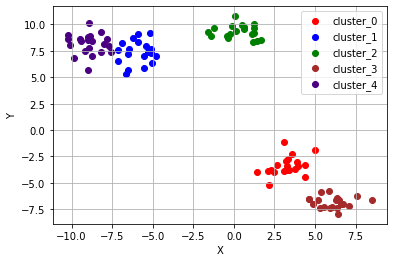

In [4]:
# 시각화

# n 번째 클러스터 데이터를 어떤 색으로 도식할 지 결정하는 color dictionary
color_dict = {0: 'red', 1: 'blue', 2:'green', 3:'brown', 4:'indigo'} 

# 점 데이터를 X-Y grid에 시각화합니다.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# K-means clustering의 결과대로 색깔별로 구분하여 점에 색칠한 후 도식
for cluster in range(5):
    cluster_sub_points = points[kmeans_cluster.labels_ == cluster] # 전체 무작위 점 데이터에서 K-means 알고리즘에 의해 군집화된 sub data를 분리합니다. 
    ax.scatter(cluster_sub_points[:, 0], cluster_sub_points[:, 1], c=color_dict[cluster], label='cluster_{}'.format(cluster)) # 해당 sub data를 plot합니다.

# 축 이름을 라벨에 달고, 점 데이터 그리기
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid()

이렇게 잘 분리되었음을 확인할 수 있다. 하지만, 주어진 데이터의 분포에 따라 의도하지 않은 결과를 초래할 수 있다.

## 3. K-means 알고리즘이 잘 동작하지 않는 예시들

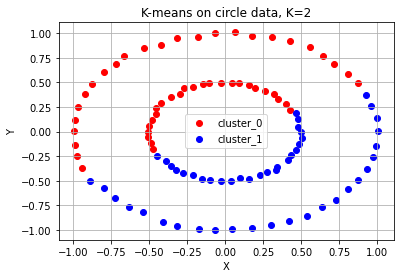

In [5]:
# K-means algorithm이 잘 동작하지 않는 예시 
# (1) 원형 분포
from sklearn.datasets import make_circles

# 원형 분포 데이터 생성
circle_points, circle_labels = make_circles(n_samples=100, factor=0.5, noise=0.01) # 원형 분포를 가지는 점 데이터 100개를 생성합니다.

# 캔버스 생성
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# 원형 분포에 대해 K-means 수행
circle_kmeans = KMeans(n_clusters=2)
circle_kmeans.fit(circle_points)
color_dict = {0: 'red', 1: 'blue'}
for cluster in range(2):
    cluster_sub_points = circle_points[circle_kmeans.labels_ == cluster]
    ax.scatter(cluster_sub_points[:, 0], cluster_sub_points[:, 1], c=color_dict[cluster], label='cluster_{}'.format(cluster))
ax.set_title('K-means on circle data, K=2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend() 
ax.grid()

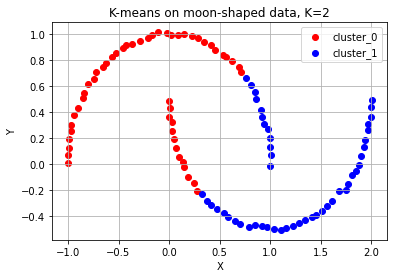

In [6]:
# K-means algorithm이 잘 동작하지 않는 예시 
# (2) 달 모양 분포
from sklearn.datasets import make_moons

# 달 모양 분포의 데이터 생성
moon_points, moon_labels = make_moons(n_samples=100, noise=0.01) # 달 모양 분포를 가지는 점 데이터 100개를 생성합니다.

# 캔버스 생성
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# 달 모양 분포 데이터 plot
moon_kmeans = KMeans(n_clusters=2)
moon_kmeans.fit(moon_points)
color_dict = {0: 'red', 1: 'blue'}
for cluster in range(2):
    cluster_sub_points = moon_points[moon_kmeans.labels_ == cluster]
    ax.scatter(cluster_sub_points[:, 0], cluster_sub_points[:, 1], c=color_dict[cluster], label='cluster_{}'.format(cluster))
ax.set_title('K-means on moon-shaped data, K=2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend() 
ax.grid()

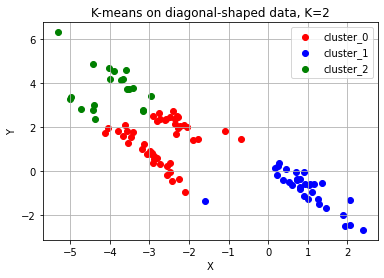

In [7]:
# K-means algorithm이 잘 동작하지 않는 예시
# (3) 대각선 모양 분포
from sklearn.datasets import make_circles, make_moons, make_blobs

# 대각선 모양 분포의 데이터 생성
diag_points, _ = make_blobs(n_samples=100, random_state=170) #대각선 분포를 가지는 점 데이터 100개를 생성합니다.(현재는 무작위 분포)
transformation = [[0.6, -0.6], [-0.4, 0.8]] #대각선 변환을 위한 대각 행렬
diag_points = np.dot(diag_points, transformation) #본 과정을 통해 무작위 분포의 점 데이터를 대각선 분포로 변환합니다.

# 캔버스 생성
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# 대각선 모양 분포 데이터 plot
diag_kmeans = KMeans(n_clusters=3)
diag_kmeans.fit(diag_points)
color_dict = {0: 'red', 1: 'blue', 2: 'green'}
for cluster in range(3):
    cluster_sub_points = diag_points[diag_kmeans.labels_ == cluster]
    ax.scatter(cluster_sub_points[:, 0], cluster_sub_points[:, 1], c=color_dict[cluster], label='cluster_{}'.format(cluster))
ax.set_title('K-means on diagonal-shaped data, K=2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend() 
ax.grid()

위 예시들을 통해 K-means 알고리즘은 다음과 같은 상황에서는 적합하지 않은 군집화 알고리즘이라는 것을 알 수 있다.
- 군집의 개수(K값)을 미리 지정해야 하기 때문에 이를 예측하기 어려운 경우 사용하기 힘들다.
- 유클리드 거리가 가까운 데이터끼리 군집이 형성되기 떄문에, 데이터 분포에 따라 유클리드 거리가 멀면서 밀접하게 연관된 데이터들의 군집화를 성공적으로 수행하지 못할 수 있다.

그렇다면 위의 경우처럼 `군집의 개수를 명시하지 않으면서 밀도 기반으로 군집을 예측하는 방법`은 없을까??

# 클러스터링(2) DBSCAN

DBSCAN(Density Based Spatial Clustering of Applications with Noise) 알고리즘은 가장 널리 알려진 밀도(density) 기반의 군집 알고리즘이다. DBSCAN 알고리즘의 가장 큰 특징 중 하나는 **군집의 개수를 미리 지정할 필요가 없다**는 점이다. 또한 유클리드 거리 기반의 K-means 알고리즘 방식과 달리, 조밀하게 몰려 있는 클러스터를 군집화하는 방식을 사용하기 때문에 원 모양의 군집이 아닌 불특정한 형태의 군집도 찾을 수 있다.

[클러스터링을 시각적으로 이해하기: DBSCAN - primo.ai](http://primo.ai/index.php?title=Density-Based_Spatial_Clustering_of_Applications_with_Noise_(DBSCAN))

K-means 알고리즘과 달리, **클러스터가 최초의 점 하나로부터** 퍼져나가는데, **그 기준이 바로 일정 반경 안의 데이터 개수, 즉 데이터 밀도이기 때문이다.**

## 1. DBSCAN 알고리즘의 동작

알고리즘을 이해하기 전에 DBSCAN을 이해하는 데 필요한 변수와 용어 정리가 필요하다.

- epsilon: 클러스터의 반경
- minPts: 클러스터를 이루는 개체의 최솟값
- core point: 반경 epsilon 내에 minPts 개 이상의 점이 존재하는 중심점
- border point: 군집의 중심이 되지는 못하지만, 군집에 속하는 점
- noise point: 군집에 포함되지 못하는 점

K-means에서 K값을 미리 지정해야 했다면, DBSCAN에서는 epsilon과 minPts 값이 미리 지정되어야 한다.

DBSCAN 알고리즘은 다음과 같은 순서로 동작한다.

1. 임의의 점 p를 설정하고, p를 포함하여 주어진 클러스터의 반경(elipson) 안에 포함되어 있는 점들의 개수를 세요.
2. 만일 해당 원에 minPts 개 이상의 점이 포함되어 있으면, 해당 점 p를 core point로 간주하고 원에 포함된 점들을 하나의 클러스터로 묶어요.
3. 해당 원에 minPts 개 미만의 점이 포함되어 있으면, 일단 pass 합시다.
4. 모든 점에 대하여 돌아가면서 1~3 번의 과정을 반복하는데, 만일 새로운 점 p'가 core point가 되고 이 점이 기존의 클러스터(p를 core point로 하는)에 속한다면, 두 개의 클러스터는 연결되어 있다고 하며 하나의 클러스터로 묶어줘요.
5. 모든 점에 대하여 클러스터링 과정을 끝냈는데, 어떤 점을 중심으로 하더라도 클러스터에 속하지 못하는 점이 있으면 이를 noise point로 간주해요. 또한, 특정 군집에는 속하지만 core point가 아닌 점들을 border point라고 칭해요.


## 2. DBSCAN 알고리즘 적용하기

이전 스텝에서 K-means 알고리즘으로는 잘 되지 않았던 예시들이 어떻게 처리되는지 보자.

# of cluster: 2
DBSCAN Y-hat: [0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1
 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0]


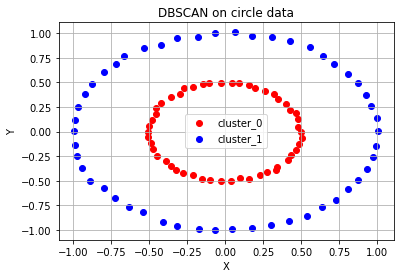

In [8]:
# DBSCAN으로 circle, moon, diagonal shaped data를 군집화한 결과
from sklearn.cluster import DBSCAN

fig = plt.figure()
ax= fig.add_subplot(1, 1, 1)
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'brown',4:'purple'} # n 번째 클러스터 데이터를 어떤 색으로 도식할 지 결정하는 color dictionary

# 원형 분포 데이터 plot
epsilon, minPts = 0.2, 3 # 2)와 3) 과정에서 사용할 epsilon, minPts 값을 설정
circle_dbscan = DBSCAN(eps=epsilon, min_samples=minPts) # 위에서 생성한 원형 분포 데이터에 DBSCAN setting
circle_dbscan.fit(circle_points) # 3) ~ 5) 과정을 반복
n_cluster = max(circle_dbscan.labels_)+1 # 3) ~5) 과정의 반복으로 클러스터의 수 도출

print(f'# of cluster: {n_cluster}')
print(f'DBSCAN Y-hat: {circle_dbscan.labels_}')

# DBSCAN 알고리즘의 수행결과로 도출된 클러스터의 수를 기반으로 색깔별로 구분하여 점에 색칠한 후 도식
for cluster in range(n_cluster):
    cluster_sub_points = circle_points[circle_dbscan.labels_ == cluster]
    ax.scatter(cluster_sub_points[:, 0], cluster_sub_points[:, 1], c=color_dict[cluster], label='cluster_{}'.format(cluster))
ax.set_title('DBSCAN on circle data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid()

# of cluster: 2
DBSCAN Y-hat: [0 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0
 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1
 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0]


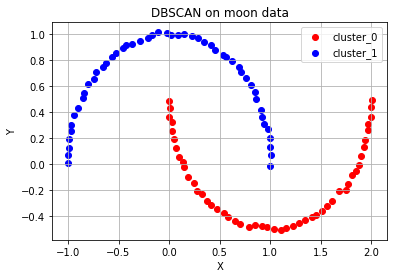

In [9]:
# 달 모양 분포 데이터 plot - 위와 같은 과정 반복
fig = plt.figure()
ax= fig.add_subplot(1, 1, 1)
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'brown',4:'purple'} # n 번째 클러스터 데이터를 어떤 색으로 도식할 지 결정하는 color dictionary

epsilon, minPts = 0.4, 3
moon_dbscan = DBSCAN(eps=epsilon, min_samples=minPts)
moon_dbscan.fit(moon_points)
n_cluster = max(moon_dbscan.labels_)+1

print(f'# of cluster: {n_cluster}')
print(f'DBSCAN Y-hat: {moon_dbscan.labels_}')

for cluster in range(n_cluster):
    cluster_sub_points = moon_points[moon_dbscan.labels_ == cluster]
    ax.scatter(cluster_sub_points[:, 0], cluster_sub_points[:, 1], c=color_dict[cluster], label='cluster_{}'.format(cluster))
ax.set_title('DBSCAN on moon data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid()

# of cluster: 3
DBSCAN Y-hat: [ 0  1  1  0  0  2  2  0  1  2  2  2  0  2  0  1  2  2  2  1  1  1  1  1
  2  2  0  1  0  2  1  0  2  1  2  0  0  0  0  0  1  0  1  0  0  2  1  1
  0  2  1  1  2  1  0  2 -1  2  0  0  2  0  0  1  0  1  1  2  2  2 -1  0
  2  0  0  0  1  2  2 -1  2  2  1  2  0  0  2  1  1  2  1  1  2  0 -1  1
  0  0  0  1]


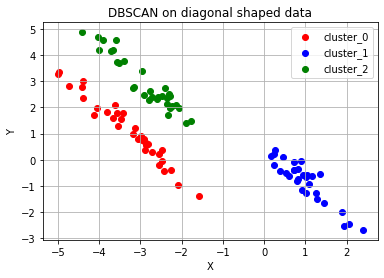

In [10]:
# 대각선 모양 분포 데이터 plot - 위와 같은 과정 반복
fig = plt.figure()
ax= fig.add_subplot(1, 1, 1)
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'brown',4:'purple'} # n 번째 클러스터 데이터를 어떤 색으로 도식할 지 결정하는 color dictionary

epsilon, minPts = 0.7, 3
diag_dbscan = DBSCAN(eps=epsilon, min_samples=minPts)
diag_dbscan.fit(diag_points)
n_cluster = max(diag_dbscan.labels_)+1

print(f'# of cluster: {n_cluster}')
print(f'DBSCAN Y-hat: {diag_dbscan.labels_}')

for cluster in range(n_cluster):
    cluster_sub_points = diag_points[diag_dbscan.labels_ == cluster]
    ax.scatter(cluster_sub_points[:, 0], cluster_sub_points[:, 1], c=color_dict[cluster], label='cluster_{}'.format(cluster))
ax.set_title('DBSCAN on diagonal shaped data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid()

DBSCAN `Y-hat` 결과가 -1인 경우가 보일텐데, 이는 **Noise Point**들이다.

위 코드에서 확인할 수 있듯이, epsilon과 minPts 값을 잘 조절해주면 DBSCAN 알고리즘에 따라 적절한 클러스터의 개수를 설정하여 주어진 데이터에 대한 군집화를 수행할 수 있다. K-means 알고리즘에 비해 훨씬 유연한 사용이 가능하기 때문에 DBSCAN은 굉장히 보편적으로 사용되는 군집화 알고리즘이다.

그렇다면 이제 DBSCAN의 단점을 알아보자.


## 3. DBSCAN 알고리즘과 K-means 알고리즘의 소요시간 비교

# of samples: 100 / Elapsed time of K-means: 0.02039s / DBSCAN: 0.00119s
# of samples: 500 / Elapsed time of K-means: 0.02446s / DBSCAN: 0.00227s
# of samples: 1000 / Elapsed time of K-means: 0.01633s / DBSCAN: 0.00480s
# of samples: 2000 / Elapsed time of K-means: 0.01732s / DBSCAN: 0.01173s
# of samples: 5000 / Elapsed time of K-means: 0.84376s / DBSCAN: 0.05249s
# of samples: 7500 / Elapsed time of K-means: 0.99464s / DBSCAN: 0.08377s
# of samples: 10000 / Elapsed time of K-means: 0.91556s / DBSCAN: 0.13821s
# of samples: 20000 / Elapsed time of K-means: 1.15868s / DBSCAN: 0.42703s
# of samples: 30000 / Elapsed time of K-means: 0.96691s / DBSCAN: 0.88631s
# of samples: 40000 / Elapsed time of K-means: 1.16361s / DBSCAN: 1.40476s
# of samples: 50000 / Elapsed time of K-means: 1.09825s / DBSCAN: 2.25771s


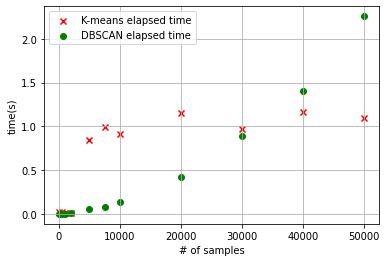

In [11]:
# DBSCAN 알고리즘과 K-means 알고리즘의 시간을 비교하는 코드 
import time

n_samples= [100, 500, 1000, 2000, 5000, 7500, 10000, 20000, 30000, 40000, 50000]

kmeans_time = []
dbscan_time = []
x = []
for n_sample in n_samples:
    dummy_circle, dummy_labels = make_circles(n_samples=n_sample, factor=0.5, noise=0.01) # 원형의 분포를 가지는 데이터 생성

    # K-means 시간을 측정
    kmeans_start = time.time()
    circle_kmeans = KMeans(n_clusters=2)
    circle_kmeans.fit(dummy_circle)
    kmeans_end = time.time()

    # DBSCAN 시간을 측정
    dbscan_start = time.time()
    epsilon, minPts = 0.2, 3
    circle_dbscan = DBSCAN(eps=epsilon, min_samples=minPts)
    circle_dbscan.fit(dummy_circle)
    dbscan_end = time.time()

    x.append(n_sample)
    kmeans_time.append(kmeans_end-kmeans_start)
    dbscan_time.append(dbscan_end-dbscan_start)
    print("# of samples: {} / Elapsed time of K-means: {:.5f}s / DBSCAN: {:.5f}s".format(n_sample, kmeans_end-kmeans_start, dbscan_end-dbscan_start))

# K-means와 DBSCAN의 소요 시간 그래프화
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, kmeans_time, c='red', marker='x', label='K-means elapsed time')
ax.scatter(x, dbscan_time, c='green', label='DBSCAN elapsed time')
ax.set_xlabel('# of samples')
ax.set_ylabel('time(s)')
ax.legend()
ax.grid()

- 위에서 알 수 있듯이, 군집화할 데이터의 수가 많아질수록 DBSCAN의 알고리즘 수행시간이 급격히 늘어난다.
- 또한, 데이터 분포에 맞는 epsilon과 minPts의 값을 지정해주어야 한다.

# 차원 축소(1) PCA

`PCA`: a statistical procedure that allows you to summarize the information content in large data tables by means of a smaller set of “summary indices” that can be more easily visualized and analyzed.

Dimensionality reduction 알고리즘은 우리에게 무엇이 더 중요한 요소인지를 알게 해주는 방법이다. 여러 feature들 중에서 어떤 특징이 가장 그 데이터를 잘 represent하는지 알게 해주는 feature extraction의 용도로 사용된다. 이를 이해하기 위해 선형대수 지식이 필요하다.

> PCA는 데이터 분포의 주성분을 찾아주는 방법이다. 여기서 주성분이라는 의미는 데이터의 분산이 가장 큰 방향벡터를 의미한다.
PCA는 데이터들의 분산을 최대로 보존하면서, 서로 직교(orthogonal)하는 기저(basis, 분산이 큰 방향벡터의 축)들을 찾아 고차원 공간을 저차원 공간으로 사영(projection)한다.
또한 PCA에서는 기존 feature 중 중요한 것을 선택하는 방식이 아닌 기존의 feature를 선형 결합(linear combination)하는 방식을 사용하고 있다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/F-44.3.png)
[타원 데이터 분포에서 주성분 분석을 통한 basis(출처: https://en.wikipedia.org/wiki/Principal_component_analysis)]

위 그림과 같이 타원형 분포로 된 데이터들이 있을 때, 차원의 수는 줄이면서 데이터 분포의 분산을 최대한 유지하기 위해 가장 분산ㄴ이 긴 축을 첫 기저로 잡고, 그 기저에 직교하는 축 중 가장 분산이 큰 값을 다음 기저로 잡게 된다. 이 과정을 반복하게 되면 차원의 수를 최대로 줄이면서 데이터 분포의 분산을 유지할 수 있다. 이를 차원 축소라고 한다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/F-44-d-reduction.jpg)
[출처 : https://www.geeksforgeeks.org/dimensionality-reduction/]

여기서 projection이라는 용어가 등장한다. PCA는 차원축소를 시도하되, 주어진 좌표축 방향이 아니라, 가장 분산이 길게 나오는(상대적으로 중요한) basis 방향을 찾아서 그 방향의 basis만 남기고, 덜 중요한 기저 방향을 삭제하는 방식으로 진행된다. 이렇게 찾은 가장 중요한 기저를 주성분(Principal Component)방향, 또는 `pc축`이라고 한다.

코드를 살펴보자.

## 1. 데이터 개요

In [12]:
# 차원 축소 예제: 유방암 데이터셋
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# 데이터 로드
cancer=load_breast_cancer()

# y=0(Malignant:악성 종양), y=1(Benign:양성 종양)
cancer_X, cancer_y= cancer.data, cancer['target']
train_X, test_X, train_y, test_y = train_test_split(cancer_X, cancer_y, test_size=0.1, random_state=10) # train 데이터셋과 test 데이터셋으로 나눔
print("전체 검사자 수: {}".format(len(cancer_X)))
print("Train dataset에 사용되는 검사자 수: {}".format(len(train_X)))
print("Test dataset에 사용되는 검사자 수: {}".format(len(test_X)))
cancer_df = pd.DataFrame(cancer_X, columns=cancer['feature_names'])
cancer_df.head()

전체 검사자 수: 569
Train dataset에 사용되는 검사자 수: 512
Test dataset에 사용되는 검사자 수: 57


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


총 30개의 feature로 구성이 되어 있고, 569rows, 각각의 row에 해당 환자가 양성/음성 종양을 갖는지에 대한 라벨이 있다.

이 유방암 데이터셋을 train, test dataset으로 나누고, train dataset과 test dataset 각각에 PCA적용해볼 것이다. 이후 차원 축소를 적용하지 않은 original data와 PCA를 적용한 data를 이용하여 SVM classifier를 훈련시킨 후, 가각의 테스트 데이터셋을 통해 정확도를 확인하는 코드를 실행해 봄으로써 PCA의 효과를 확인해보자.

## 2. 유방암 데이터셋에 PCA 알고리즘 적용 예제

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score
from collections import Counter

# color dictionary
color_dict = {0: 'red', 1: 'blue', 2:'red', 3:'blue'}
target_dict = {0: 'malignant_train', 1: 'benign_train', 2: 'malignant_test', 3:'benign_test'}

#Train data에 PCA 알고리즘 적용
train_X_ = StandardScaler().fit_transform(train_X) # 불러온 데이터에 대한 정규화 -> 각 column의 range of value가 전부 다르기 때문에 정규화를 진행해 주어야 합니다.
train_df = pd.DataFrame(train_X_, columns=cancer['feature_names'])
pca = PCA(n_components=2) # 주성분의 수를 2개, 즉 기저가 되는 방향벡터를 2개로 하는 PCA 알고리즘 수행
pc = pca.fit_transform(train_df)

#Test data에 PCA 알고리즘 적용
test_X_ = StandardScaler().fit_transform(test_X) # normalization
test_df = pd.DataFrame(test_X_, columns=cancer['feature_names'])
pca_test = PCA(n_components=2)
pc_test = pca_test.fit_transform(test_df)

`StandScaler().fit_transform()`과정을 수행하는 이유: 각 열마다의 값 범위가 전부 달라서, scaling을 하여 값의 영향력을 같게 하기 위해

In [16]:
# 훈련한 classifier의 decision boundary를 그리는 함수
def plot_decision_boundary(X, clf, ax): 
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z, cmap='Blues')

# PCA를 적용한 train data의 classifier 훈련: classfier로 Support Vector Machine(SVM) 사용
clf = svm.SVC(kernel = 'rbf', gamma=0.5, C=0.8) # 여기서는 classifier로 SVM을 사용한다는 정도만 알아둡시다!
clf.fit(pc, train_y) # train data로 classifier 훈련

# PCA를 적용하지 않은 original data의 SVM 훈련
clf_orig = svm.SVC(kernel = 'rbf', gamma=0.5, C=0.8) # 여기서는 classifier로 SVM을 사용한다는 정도만 알아둡시다!
clf_orig.fit(train_df, train_y)

SVC(C=0.8, gamma=0.5)

여기서는 SVM classifer를 훈련시키자. 이 classifier는 PC(주성분)을 기반으로 해당 점이 양성인지/악정인지 구분해주는 결정 경계선(Decision boundary)에 해당하는데, train data에 맞게 경계선이 그어질 수 있도록 이를 훈련시키는 단계에 해당한다.

[SVM에 대한 추가설명](https://ko.wikipedia.org/wiki/%EC%84%9C%ED%8F%AC%ED%8A%B8_%EB%B2%A1%ED%84%B0_%EB%A8%B8%EC%8B%A0)

PCA 분석을 사용한 Test dataset accuracy: 54명/57명 => 0.947
PCA를 적용하지 않은 Test dataset accuracy: 43명/57명 => 0.754


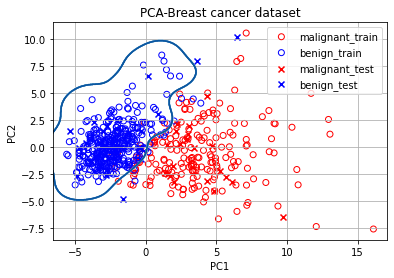

In [18]:
# 캔버스 도식
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# malignant와 benign의 SVM decision boundary 그리기
plot_decision_boundary(pc, clf, ax)

#Train data 도식
for cluster in range(2):
    sub_cancer_points = pc[train_y == cluster]
    ax.scatter(sub_cancer_points[:, 0], sub_cancer_points[:, 1], edgecolor=color_dict[cluster], c='none', label=target_dict[cluster])
#Test data 도식
for cluster in range(2):
    sub_cancer_points = pc_test[test_y == cluster]
    ax.scatter(sub_cancer_points[:, 0], sub_cancer_points[:, 1], marker= 'x', c=color_dict[cluster+2], label=target_dict[cluster+2])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA-Breast cancer dataset')
ax.legend()
ax.grid()

# Scoring
pca_test_accuracy_dict = Counter(clf.predict(pc_test) == test_y)
orig_test_accuracy_dict = Counter(clf_orig.predict(test_df) == test_y)

print("PCA 분석을 사용한 Test dataset accuracy: {}명/{}명 => {:.3f}".format(pca_test_accuracy_dict[True], sum(pca_test_accuracy_dict.values()), clf.score(pc_test, test_y)))
print("PCA를 적용하지 않은 Test dataset accuracy: {}명/{}명 => {:.3f}".format(orig_test_accuracy_dict[True], sum(orig_test_accuracy_dict.values()), clf_orig.score(test_df, test_y)))

이렇게 정확도의 차이가 발생하게 된다. 모든 feature를 이용한 방식의 정확도가 더 낮은 이유 중 하나는 제공된 30개의 feature 중 종양의 약성/악성과 관련없는 것이 존재해서 해당 feature가 오히려 분류를 방해했기 때문이다!

# 차원 축소(2) T-SNE

이번엔 **T-SNE(T0SSStochastic Neighbor Embdding)**라는 `시각화에 많이 사용되는 알고리즘`을 살펴보자.

우리의 현실세계는 3차원이기 떄문에, 그 이상의 차원을 인지하기 힘들다. 따라서 고차원 데이터를 1~3차원으로 불러와야 비로소 시각적으로 데이터를 이해할 것이다.

물론, 시각화도 PCA로 하면 된다는 생각이 들겠지만, 차원축소의 목적에 따라/데이터의 어떤 정보를 보존할 것이냐에 따라 적합한 알고리즘이 있다.

예를 들어, PCA는 주로 선형적인 데이터 분포를 가지고 있을 때, 정보가 가장 잘 보존된다.

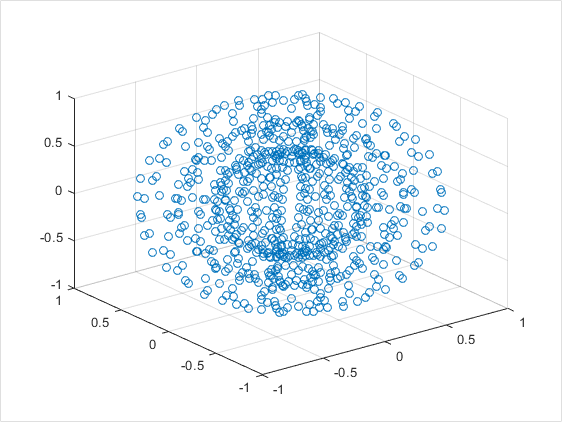

위 이미지처럼 방사형/비선형적 데이터에서는 주성분(Principal Component)으로 잡을 선형적인 축을 찾기 어렵다.

그래서, 이번에 배울 T-SNE는 **기존 차원의 공간에서 가까운 점들은, 차원축소된 공간에서도 여전히 가깝게 유지되는 것을 목표로**하고 있다. 이 특징 덕분에 MNIST 784차원의 숫자 이미지를 2차원으로 시각화하여도, 같은 숫자 이미지끼리 유사한 거리에 놓인 것을 확인해볼 수 있을 것이다.

즉, **PCA는 데이터의 고유한 물리적 정보량을 보존하는 데 주력하지만, T-SNE는 데이터 간의 상대적 거리를 보존하는 데 주력한다**.

## 0. 사이킷런(scikit-learn)에서 MNIST 데이터 불러오기
`sklearn.datasets `패키지에서 제공하는 `fetch_openml` 함수를 사용하여 MNIST 데이터를 가져온다.

In [34]:
print("실행 중입니다... 시간이 다소 걸릴 수 있어요. :)\n===")

from sklearn.datasets import fetch_openml

# 784 pixel로 이뤄진 mnist 이미지 데이터 호출
mnist = fetch_openml("mnist_784",version=1)

X = mnist.data / 255.0
y = mnist.target
print("X shape: ",X.shape)
print("Y shape: ",y.shape)

실행 중입니다... 시간이 다소 걸릴 수 있어요. :)
===
X shape:  (70000, 784)
Y shape:  (70000,)


In [35]:
n_image = X.shape[0]
n_image_pixel = X.shape[1]

pixel_columns = [ f"pixel{i}" for i in range(1, n_image_pixel + 1) ] #  픽셀정보가 있는 칼럼의 이름을 담은 목록
print(pixel_columns[:5])
len(pixel_columns)

['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5']


784

In [36]:
# 사용하기 쉽게 Pandas Dataframe으로 만들기

import pandas as pd

df = pd.DataFrame(X,columns=pixel_columns)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i)) # 숫자 라벨을 스트링으로 만드는 함수를 파이썬 람다 문법으로 전체 데이터에 적용합니다.
X, y = None, None

In [37]:
# 7만 개의 이미지 데이터 중 1만 개를 랜덤샘플링

import numpy as np

# 결과가 재생산 가능하도록 랜덤 시드를 지정합니다.
np.random.seed(30)

# 이미지 데이터의 순서를 랜덤으로 뒤바꾼(permutation) 배열을 담습니다.
rndperm = np.random.permutation(n_image)

# 랜덤으로 섞은 이미지 중 10,000개를 뽑고, df_subset에 담습니다.
n_image_sample = 10000
random_idx = rndperm[:n_image_sample]
df_subset = df.loc[random_idx,:].copy()
df_subset.shape

(10000, 786)

<Figure size 432x288 with 0 Axes>

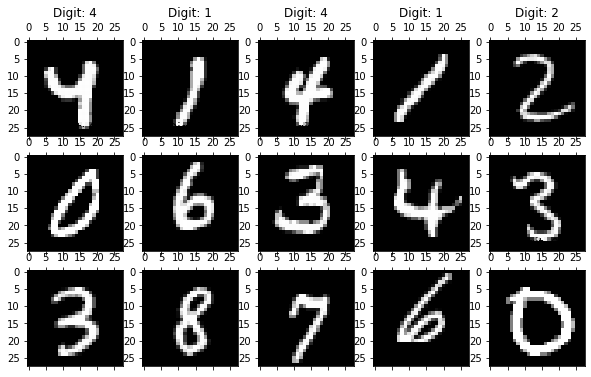

In [38]:
# 판다스 데이터프레임에 올린 데이터셋을 matplot 라이브러리를 사용해서 확인

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.gray()
fig = plt.figure( figsize=(10,6) )
n_img_sample = 15
width,height = 28,28

# 15개 샘플을 시각화해 봅니다. 
for i in range(0,n_img_sample):
    row = df_subset.iloc[i]
    ax = fig.add_subplot(3,5,i+1, title=f"Digit: {row['label']}")
    ax.matshow(row[pixel_columns]
               .values.reshape((width,height))
               .astype(float))

plt.show()

# 1. PCA 를 이용한 MNIST 차원축소

사이킷런에서 제공하는 PCA 모듈을 사용하여 차원을 축소할 수 있다.

In [39]:
from sklearn.decomposition import PCA

print("df_subset의 shape: {}".format(df_subset.shape))

n_dimension = 2 # 축소시킬 목표 차원의 수
pca = PCA(n_components=n_dimension)

pca_result = pca.fit_transform(df_subset[pixel_columns].values) # 차원을 축소한 결과
df_subset['pca-one'] = pca_result[:,0] # 축소한 결과의 첫 번째 차원 값
df_subset['pca-two'] = pca_result[:,1] # 축소한 결과의 두 번째 차원 값

print("pca_result의 shape: {}".format(pca_result.shape))

df_subset의 shape: (10000, 786)
pca_result의 shape: (10000, 2)


Principal Component별로 보존하는 정보량을 확인하자.

- 차원을 축소한 댓가로 차원의 정보량 중 일부만 남게 된다.
- sklearn의 PCA 모듈을 `PC 축`마다 보존하는 정보량의 비율을 제시해 준다.

In [41]:
print(f"pca-1: {round(pca.explained_variance_ratio_[0],3)*100}%")
print(f"pca-2: {round(pca.explained_variance_ratio_[1],3)*100}%")

# 784차원을 2차원으로 축소했을 때 -> 정보량이 전체의 16.9%(9.6% + 7.3%)가 남게 된다.

pca-1: 9.6%
pca-2: 7.3%


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

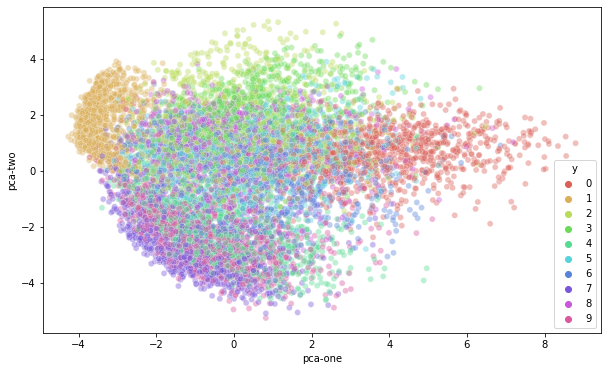

In [48]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,   # 2개의 PC축만 남은 데이터프레임 df_subset 을 시각화해 보자.
    legend="full",
    alpha=0.4
)

## 2. T-SNE를 이용한 MNIST 차원 축소

이번엔 T-SNE 모듈을 사용하여 동일한 1만 개의 이미지 데이터의 차원을 축소해보자.

[scikit-learn 공식 문서: TSNE 모듈](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)

In [51]:
from sklearn.manifold import TSNE

print("df_subset의 shape: {}".format(df_subset.shape))

data_subset = df_subset[pixel_columns].values
n_dimension = 2
tsne = TSNE(n_components=n_dimension)
tsne_results = tsne.fit_transform(data_subset)

print("tsne_results의 shape: {}".format(tsne_results.shape))

df_subset의 shape: (10000, 788)
tsne_results의 shape: (10000, 2)


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

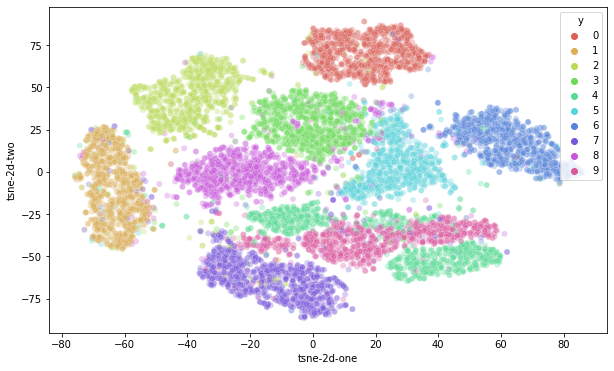

In [52]:
# tsne 결과를 차원별로 추가합니다.
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

# 시각화해 봅니다.
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

이렇게 PCA로 축소해 시각화한 결과와 차이점이 드러날 것이다!!

앞서 언급한 내용을 다시 상기해보자.

> T-SNE는 기존 차원의 공간에서 가까운 점들은, 차원축소된 공간에서도 여전히 가깝게 유지하는 것을 목표로 한다. 그렇기에 MNIST의 784 차원의 숫자 이미지를 2차원으로 시각화하여도 같은 숫자 이미지끼리는 유사한 거리에 놓인 것을 확인할 수 있을 것이다.

T-SNE에서는 고차원에서 먼 거리의 두 점은 저차원에서도 먼 거리에 있어야 한다! 결과적으로 T-SNE를 시각화하면 숫자들 사이의 경계가 뚜렷이 나타나는 장점이 있다. 위에서 T-SNE를 훈련시켰을 때 label 정보를 전혀 참조하지 않고 `df_subset[pixel_columns]`정보만 참고하여 얻은 결과라는 점에 주목하자. 그래서 T-SNE는 분류기의 Feature Extracotr 모델이 카테고리 간 분류 경계선을 뚜렷하게 유지하는지를 확인하는 용도로 자주 쓰인다.

하지만, T-SNE의 저차원은 물리적 의미를 가지지 않는다. PCA는 정보 손실을 최소화하려는 관점을 가지므로, 추출된 PC축은 주성분이라는 물리적 의미를 유지하고 있으며, 공분산을 통해 원본 데이터를 일정 부분 복원할 수 있는 가능성이 있다. 하지만 T-SNE는 정보 손실량에 주목하지 않기 때문에 저차원 축은 아무런 물리적 의미를 지니지 못하며 시각화에만 유리하다.

# 정리 및 요약

자금까지 4가지 알고리즘에 대해 살펴보았다. 이외에도 GAN 등의 딥러닝을 이용한 생성 모델 등 다양한 방법들이 비지도학습의 축을 담당하고 있다. 

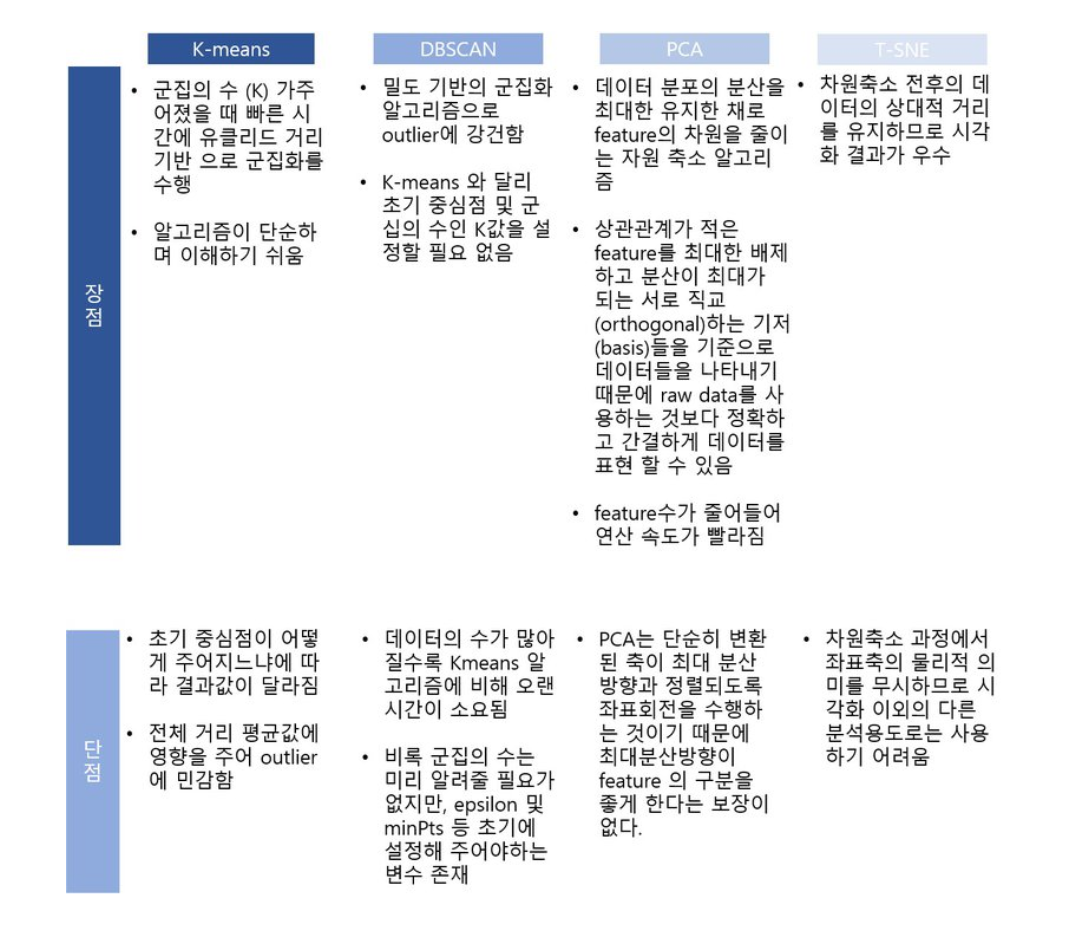